In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple

import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

import shap

from visualization import plot_predicted_vs_true

In [3]:
np.set_printoptions(suppress=True)

## Data Loading

In [4]:
train_data_full = pd.read_csv("data/train_data.csv", sep=";")
test_data_full = pd.read_csv("data/test_data.csv", sep=";")

train_data_full= train_data_full[train_data_full["attention_check"] == 1]

In [5]:
predictors = ['rel_1', 'rel_2', 'rel_3', 'rel_4', 'rel_5', 'rel_6', 'rel_7', 'rel_8', 'rel_9', \
              'cnorm_1', 'cnorm_2', 'age', 'gender', 'ethnicity', 'education', 'gdp', 'gdp_scaled', \
              'sample_type', 'compensation', 'denomination', 'country', 'ses']
regression_targets = ['wb_overall_mean', 'wb_phys_mean', 'wb_psych_mean', 'wb_soc_mean']
# regression_targets = ['wb_overall_mean']


def justify_X(X: 'pd.DataFrame', use_wb_soc_3: bool = False) -> 'pd.DataFrame': 
    # List needed dummies
    dummies_needed = ['rel_3', 'rel_4', 'gender', 'ethnicity', 'sample_type', 'compensation', 'denomination', 'country']
    scaling_needed = list(filter(lambda x: x not in dummies_needed, predictors))
    if use_wb_soc_3: 
        dummies_needed.append('answered_sex_life_question')

    # Grab predictor columns
    X_new = X[predictors]

    # Get whether they answered the sexlife question as its own variable
    if use_wb_soc_3: 
        X_new.loc[:, 'answered_sex_life_question'] = X['wb_soc_3'].isna()

    # Do imputations
    for column in X_new.columns: 
        if sum(X_new[column].isna()) == 0:
            continue
        if column not in dummies_needed: 
            X_new[column] = X_new[column].fillna(X_new[column].mean())

    # Do scaling
    scaler = StandardScaler()
    X_new[scaling_needed] = scaler.fit_transform(X_new[scaling_needed])
    
    # Get dummies
    dummies_with_na = list(filter(lambda x: sum(X_new[x].isna()) > 0, dummies_needed))
    dummies_without_na = list(filter(lambda x: x not in dummies_with_na, dummies_needed))
    X_new = pd.get_dummies(X_new, columns=dummies_with_na, dummy_na=True)
    return(pd.get_dummies(X_new, columns=dummies_without_na, dummy_na=False))


def justify_data(data: 'pd.DataFrame', use_wb_soc_3: bool = True, test_size: float = .2, seed: int = 42, random: bool = False) -> \
            Tuple['pd.DataFrame', 'pd.DataFrame', 'pd.DataFrame', 'pd.DataFrame']: 
    
    X = justify_X(data, use_wb_soc_3=use_wb_soc_3)
    y = data[regression_targets]
    
    if random: 
        return train_test_split(X, y, test_size=test_size)
    return train_test_split(X, y, test_size=test_size, random_state=seed)

In [6]:
X_train_w_soc3, X_test_w_soc3, y_train_w_soc3, y_test_w_soc3 = justify_data(train_data_full)
X_train, X_test, y_train, y_test = justify_data(train_data_full, use_wb_soc_3=False)
X_real_world = justify_X(test_data_full, use_wb_soc_3=False)

# The test data (here calleed "real_word") is missing some of the categories present
#   in the training data, making the results of the get_dummies() funciton 
#   incomplete. This code fixes that problem.
X_train, X_real_world = X_train.align(X_real_world, join='left', axis=1)
X_real_world = X_real_world.fillna(0)

/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_33453/433342727.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new.loc[:, 'answered_sex_life_question'] = X['wb_soc_3'].isna()
/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_33453/433342727.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[column] = X_new[column].fillna(X_new[column].mean())
/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_33453/433342727.py:31: SettingWithCopyWarning: 
A value is trying to be 

## Linear Model

In [7]:
# Model definition and fit
lr_fit = LinearRegression().fit(X_train, y_train)

0.6415166333089468


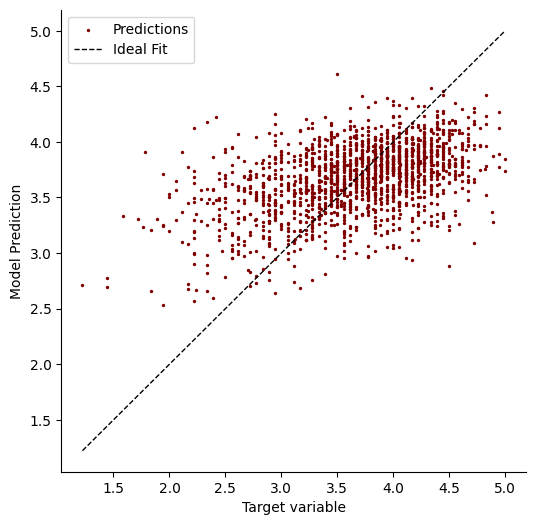

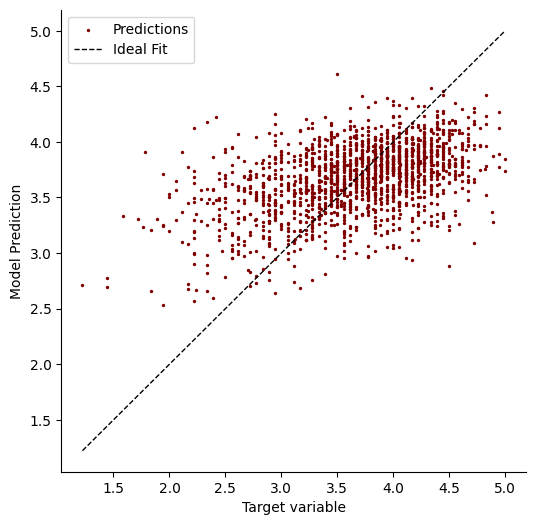

In [8]:
# Basic metrics
lr_preds = lr_fit.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, lr_preds)
print(lr_rmse)

plot_predicted_vs_true(lr_preds[:,0], y_test['wb_overall_mean'])

## Random Forest

In [117]:
# Model definition and fit
rfr = RandomForestRegressor(
    n_estimators=500,          # Number of trees
    max_depth=10,              # Limit the depth of each tree
    min_samples_split=5,       # Minimum samples required to split a node
    min_samples_leaf=3,        # Minimum samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider for splitting at each node
    random_state=42            # For reproducibility
)
rfr.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=500, random_state=42)

In [118]:
# Basic metrics
rf_preds = rfr.predict(X_test)
rf_rmse = root_mean_squared_error(y_test, rf_preds)
print(rf_rmse)

plot_predicted_vs_true(rf_preds[:,0], y_test['wb_overall_mean'])

0.6453706970300604


## Neural Network

In [120]:
# Model definition and fit
nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(4, activation="linear")
])

# Spe fy the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compiling the model
nn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["root_mean_squared_error"])

# Training the model
history = nn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=150, validation_split=0.1)

Epoch 1/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.6038 - root_mean_squared_error: 3.0666 - val_loss: 0.6398 - val_root_mean_squared_error: 0.7999
Epoch 2/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5948 - root_mean_squared_error: 0.7711 - val_loss: 0.5367 - val_root_mean_squared_error: 0.7326
Epoch 3/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5077 - root_mean_squared_error: 0.7125 - val_loss: 0.5136 - val_root_mean_squared_error: 0.7166
Epoch 4/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4833 - root_mean_squared_error: 0.6951 - val_loss: 0.5007 - val_root_mean_squared_error: 0.7076
Epoch 5/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4585 - root_mean_squared_error: 0.6770 - val_loss: 0.4983 - val_root_mean_squared_error: 0.7059
Epoch 6/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4463 - root_mean_squared_error: 0.6680 - val_loss: 0.4942 - val_root_mean_squared_error: 0.7030
Epoch 7/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

In [ ]:
# Basic metrics
nn_preds = nn_model.predict(X_test)
nn_rmse = root_mean_squared_error(y_test, nn_preds)
print(nn_rmse)

plot_predicted_vs_true(nn_preds[:,0], y_test['wb_overall_mean'])

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
0.7268812656402588


## Predictions

Based on the above graphs and RMSE values, we believe the linear model is the best; this is what we'll use to make predictions.

In [131]:
submission_preds = lr_fit.predict(X_real_world)
submission_df = pd.DataFrame(submission_preds, columns=regression_targets)

submission_df.to_csv('predictions.csv', index=False, float_format="%.4f", sep=";")

# Feature Importance

## Permutation importance calculations

In [126]:
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

lr_r = permutation_importance(lr_fit, X_test, y_test, n_repeats=30, random_state=42, scoring=scorer)
rf_r = permutation_importance(rfr, X_test, y_test, n_repeats=30, random_state=42, scoring=scorer)
nn_r = permutation_importance(nn_model, X_test, y_test, n_repeats=30, random_state=42, scoring=scorer)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 

## Permutation importance reporting

In [ ]:
def write_permutation_importances(r, model_type: str, print_vals: bool = True): 
    importances = r.importances_mean  
    importances_std = r.importances_std 
    feature_names = X_test.columns

    # Create a DataFrame with features and their importance values
    r_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Importance_std': importances_std
    })

    # Sort the DataFrame by importance (descending order) to find the most important features
    r_importance_df = r_importance_df.sort_values(by='Importance', ascending=False)

    # Print the features with the greatest importance
    r_importance_df.to_csv(model_type + "_permutation_importances.csv", index=False, float_format="%.4f", sep=";")
    if print_vals:
        r_importance_df.head(10)

write_permutation_importances(lr_r, "linearmodel")
write_permutation_importances(rf_r, "randomforest")
write_permutation_importances(nn_r, "neuralnet")

## Shapley Value Calculations

In [134]:
lr_explainer = shap.LinearExplainer(lr_fit, X_train)
lr_shap_values = lr_explainer.shap_values(X_test)[:,:,0]

## Shapley Value Reporting

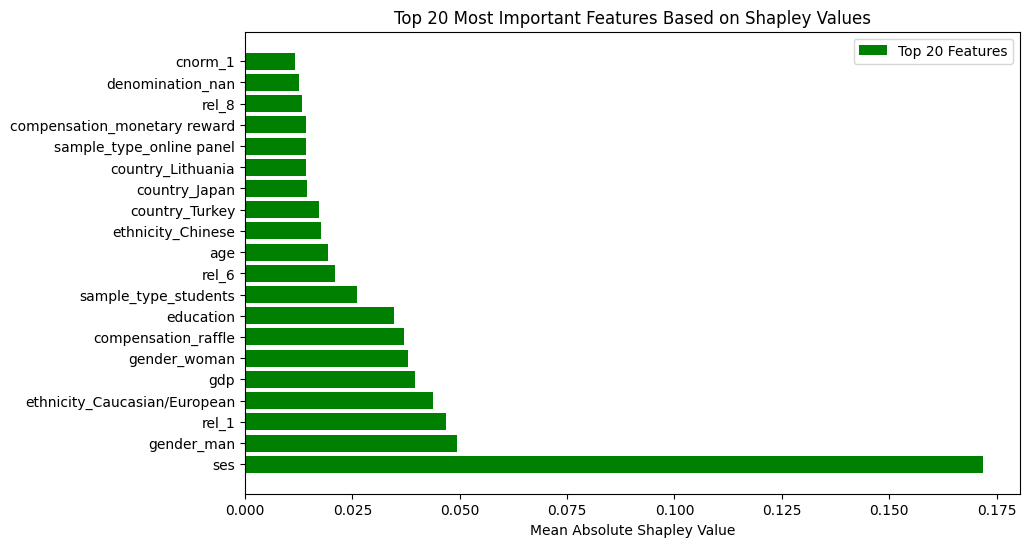

In [135]:
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Get the feature names (assuming X_test is a pandas DataFrame)
features = X_test.columns if isinstance(X_test, pd.DataFrame) else np.arange(X_test.shape[1])

# Sort the features by the mean absolute Shapley values
sorted_idx = np.argsort(mean_shap_values)[::-1]
top_20 = sorted_idx[:20]

# Prepare data for the plot
top_20_values = mean_shap_values[top_20]
top_20_features = [features[i] for i in top_20]

# Plot the 10 most and 10 least important features
plt.figure(figsize=(10, 6))

# Plot top 10 important features
plt.barh(top_20_features, top_20_values, color='green', label='Top 20 Features')

# Add labels and title
plt.xlabel("Mean Absolute Shapley Value")
plt.title("Top 20 Most Important Features Based on Shapley Values")
plt.legend()

# Show the plot
plt.show()